# Assignment objective

We have data from Raleigh, NC, where we recently deployed a flyer program in order to increase public awareness of the possibility of taking a Pagaya loan. You objective is to assess the potency of the flyer program in terms of activation by analyzing production and TU data obtained from the town.


# Basic imports 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random

# Statistical tests, validations and values
from statsmodels.stats.multitest import multipletests
from scipy import stats
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import norm

# Formats text annotations in matplotlib plots
from matplotlib.ticker import FormatStrFormatter

# Supress warnings
import warnings
warnings.filterwarnings('ignore')

# Data preparation

## Data from TU 

To begin with, upload TUs credit information from the relevant quarter (which is 2018Q3). This data is available in our `s3` path under the name `tu_gen_data2018Q3.parquet`. To get to our `s3` path import `DATA_FILES_PATH` from `pagayapro.paths.data_paths`

In [2]:
from pagayapro.paths.data_paths import DATA_FILES_PATH

read the parquet file from `s3`. Only read the columns ["sequence_num", "credit_score", "listing_term", "int_rate", "loan_amnt", "monthly_pmt", "original_state"]

In [3]:
tu_data= pd.read_parquet(
    os.path.join(DATA_FILES_PATH,"tu_gen_data_2018Q3.parquet"),
                columns = ["sequence_num", "credit_score", 
                           "listing_term", "int_rate" ,
                           "loan_amnt", "monthly_pmt", 
                           "original_state"])

Output the first 5 rows of tu_data

In [4]:
tu_data.head()

,sequence_num,credit_score,listing_term,int_rate,loan_amnt,monthly_pmt,original_state
id,,,,,,,
adf5219e4cb985352184eb7fa597737e4a9777f7354f7a8a58270da147792561,d0820401b209782dae4284b3dd96b41e08c3e8566fbb33...,814,36.0,7.86,5500.0,172.0,MI
0a0f130443af4c6597bb074942970eaddeb125d398e2cca42175c56befc8a171,2f05cd66cb998e5e55f6f296344b271b2b89b996c7c037...,800,36.0,7.91,20000.0,626.0,NM
4ba9c6a38b650ee06b8b88a48621bd363cdf611e63400c6fc4bbffbd1bf20c47,20bdbfaf0006db032d8a4176add08fd4ef45abfb17c474...,653,36.0,30.51,3674.0,157.0,SD
dae3a344292e07d4b8935a453c37aef01303f21b2f37ccbd1c4408f158533acb,53084498c6bf053a4d1cf309e1b8ec234e503bb1a3dd4e...,623,60.0,23.46,14056.0,400.0,NC
8af2ae2462d012e4d85aa687a16a4f5fb64525928235da43c795f73dc0cadd04,f750c4ecac12ae1c156998ed3dff3f46d2d19f37250074...,627,60.0,25.55,8659.0,257.0,TN


## Activation data 

Your data regarding activation arrives as forms, detailing the loan amount, interest rate offered to the client and whether he or she accepted the offer. These are available on the assignment's `s3` path, which you can import from `pagayapro.path.data_paths` under the name `ASSIGNMENT1_DATA`, in the subdirectory `offers`. 

In [5]:
from pagayapro.paths.data_paths import ASSIGNMENT1_DATA
import glob

Read all files in the subdirectory `offers` of `ASSIGNMENT1_DATA` whose name contains the substring `raleigh`.

In [6]:
raleigh_forms= (
    glob.glob(
        os.path.join(ASSIGNMENT1_DATA,"offers/*raleigh*")
    )
)

how many forms are there?


In [7]:
print('There are {0} Raleigh forms'.format(len(raleigh_forms)))

There are 769 Raleigh forms


Read all the form files and create a table which contains only the last offer given to each borrower. Call this dataframe `raleigh_df`.

In [8]:
raleigh_df= pd.concat([pd.read_csv(path) for path in raleigh_forms])
raleigh_df_origin = raleigh_df.sort_values('offer_date')
raleigh_df = raleigh_df_origin.copy().groupby('id').last()

How many rows are there in your table? How many distict ids?

In [9]:
print("Our table contains {0} rows".format(raleigh_df.shape[0]))

Our table contains 8792 rows


In [10]:
print("Our table contains {0} distinct ids".format(raleigh_df.index.unique().shape[0])) 

Our table contains 8792 distinct ids


How can you explain the duplicate ids? Sample 5 ids with multiple lines and display them.

There were no duplicate ID's since we've dropped all but the last loan offer, based on ID.

Drop all lines in the dataframe which contain irrelevant information.


In [11]:
raleigh_df.requested_amount.sort_values().tail(10)

id
c2401eafe53ffea3c2959e5afd4a3d9fb46d1ab9c7a3c3f07582a48d23df7cd9     60000.0
8c42acab08f57bf09526e756f51b01756622b24e6949ec2bc32b6b8651b379e4     60000.0
d6c61f0a864242801384bffdb350ea6b7bb0cd546d887d4be25d9b053bc0ea3e     60150.0
1aa0efc9470618a3366ffa02a679a9b6ca328f7f0894b8827eeff5f9192794ec     80000.0
4d88fafd8adcd203f69bd9fcfdba8f9173b4fbfff5bdca04db2a37fce293c702     80000.0
15011c706668f4cddbf00b822d1e9d434e1ef38b3cc139dc9ca68b362c97a75a    100000.0
12f39bfa456df3a843f7b3e178b5fb1cbd42693608c09f4edbe2d191089484fe    100000.0
86948a3a67602bf26cb49e6cd21329607da54b7b6ac473a8656f1c21a1d2da28    100000.0
040132ec36e344771ed686c0905f40fb92fb707fc7f05271b0ad98be042aaf75    100000.0
3d92c47347b3a7ec8322484ae1a9c6f274b738d9968e8486e630f3cae75307fe    200200.0
Name: requested_amount, dtype: float64

We saw that there are less than 10 loans that has requested amount > 60150. We will drop those outliers.


In [12]:
raleigh_df = raleigh_df[raleigh_df.requested_amount <= 60150]
tu_data = tu_data[tu_data.loan_amnt <= 60150]

What is the average interest rate offered to clients? What is the average among clients who accepted the offer?

In [13]:
print("The average interest rate offered: {0}%".format(round(raleigh_df.offered_interest_rate.mean(), 3)))

print("The average interest rate offered to those who accepted: {0}%".format(round(raleigh_df[raleigh_df.offer_accepted].offered_interest_rate.mean(), 3)))

The average interest rate offered: 15.53%
The average interest rate offered to those who accepted: 15.324%


What is the percentage of activation in this dataframe?

In [14]:
print("Activation percentage: {0}%".format(round(raleigh_df.offer_accepted.mean()*100, 3)))

Activation percentage: 8.651%


Enrich your dataframe with additioanl TU features by merging it with the `tu_data` df. Note that the two dataframe share the `id` and `sequence_num` features.

In [15]:
merged_raleigh = pd.merge(raleigh_df, tu_data,  how='left', left_on=['id','sequence_num'], right_on =['id','sequence_num'])

What is the average credit score of the clients? What is the average among clients who accepted the offer?

In [16]:
print("The average credit score: {0}".format(round(merged_raleigh.credit_score.mean(), 3)))

print("The average credit score for those who accepted: {0}".format(round(merged_raleigh[merged_raleigh.offer_accepted].credit_score.mean(), 3)))

The average credit score: 689.858
The average credit score for those who accepted: 702.353


We also want to remove irrelevant credit scores, those under 450.

In [17]:
print('There are {0} invalid credit scores in Raleigh and {1} in the General Population'.format(merged_raleigh.credit_score[merged_raleigh.credit_score < 450].shape[0],
                                                                                                tu_data.credit_score[tu_data.credit_score < 450].shape[0]))

There are 18 invalid credit scores in Raleigh and 2194 in the General Population


A tiny amount compared to the size of each dataset.

In [18]:
merged_raleigh = merged_raleigh[merged_raleigh.credit_score >= 450]
tu_data = tu_data[tu_data.credit_score >= 450]

# Validations

Before we embark on a statistical test, let's do some validations to make sure that the Raleig sample is not somehow distinct from the general population. Our random sample from the general population is the TU data.

Create a histogram to describe the distribution of requested loan amounts in Raleigh and in the general population. Do the distributions look similar? (A good rule-of-thumb for the number of bins to use is the square-root of the number of unique value.)

In [19]:
def hist_pair(ral_df, pop_df, col, ral_title, pop_title, xlabel, xlim=None, ylim=None, bins=None):
    sns.set_theme(style="ticks")
    
    # Raleigh Data Presentation
    plt.subplot(1, 2, 1)
    plt.rcParams["figure.figsize"] = (9,7)
    
    
    if not bins:
        bins = int(ral_df.index.unique().shape[0]**0.5)

    sns.histplot(
        ral_df,
        x=col,
        palette="light:m_r",
        edgecolor=".3",
        linewidth=.5,
        bins = bins,
        stat = 'probability')
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    plt.title(ral_title, fontweight='bold')
    plt.xlabel(xlabel)
    
    # Total Population Data Presentation
    plt.subplot(1, 2, 2)
    plt.rcParams["figure.figsize"] = (9,6)

    sns.histplot(
        pop_df,
        x=col,
        palette="light:m_r",
        edgecolor=".3",
        linewidth=.5,
        bins = bins,
        stat = 'probability')
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    plt.title(pop_title, fontweight='bold')
    plt.xlabel(xlabel)
    
    # Present the plots
    plt.tight_layout()
    plt.show()    

In [20]:
def density_pair(ral_df, pop_df, col, ral_title, pop_title, xlabel, xlim=None, ylim=None):
    
    # Fig and Axes
    fig, ax = plt.subplots(nrows=2, ncols=2, sharex=True, 
                                        gridspec_kw={"height_ratios": (.15, .85)})

    # Raleigh Density
    sns.boxplot(x=ral_df[col], ax=ax[0][0])
    sns.distplot(ral_df[col], ax=ax[1][0])

    ax[0][0].set(yticks=[])
    sns.despine(ax=ax[1][0])
    sns.despine(ax=ax[0][0], left=True)
    ax[1][0].set_xlabel(xlabel)
    ax[0][0].set_xlabel('')
    ax[0][0].set_title(ral_title, fontweight='bold')
  
    # General Population Density
    sns.boxplot(x=pop_df[col], ax=ax[0][1])
    sns.distplot(pop_df[col], ax=ax[1][1])

    ax[0][1].set(yticks=[])
    sns.despine(ax=ax[1][1])
    sns.despine(ax=ax[0][1], left=True)
    ax[1][1].set_xlabel(xlabel)
    ax[0][1].set_xlabel('')
    ax[0][1].set_title(pop_title, fontweight='bold')
    
    if xlim:
        for i in range(1):
            for j in range(1):
                ax[i][j].set_xlim(xlim[0], xlim[1])
    if ylim:
        for j in range(1):
                ax[1][j].set_ylim(ylim[0], ylim[1])       
    
    # Present the plots
    fig.set_size_inches(10, 8, forward=True)
    plt.tight_layout()
    plt.show()    


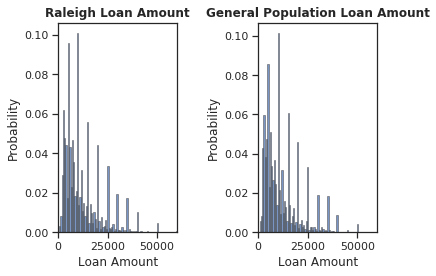

In [21]:
# Plot the loan amount histograms
hist_pair(ral_df=merged_raleigh,
          pop_df=tu_data,
          col='loan_amnt',
          ral_title='Raleigh Loan Amount',
          pop_title='General Population Loan Amount',
          xlabel='Loan Amount',
          xlim=(0, 60150))


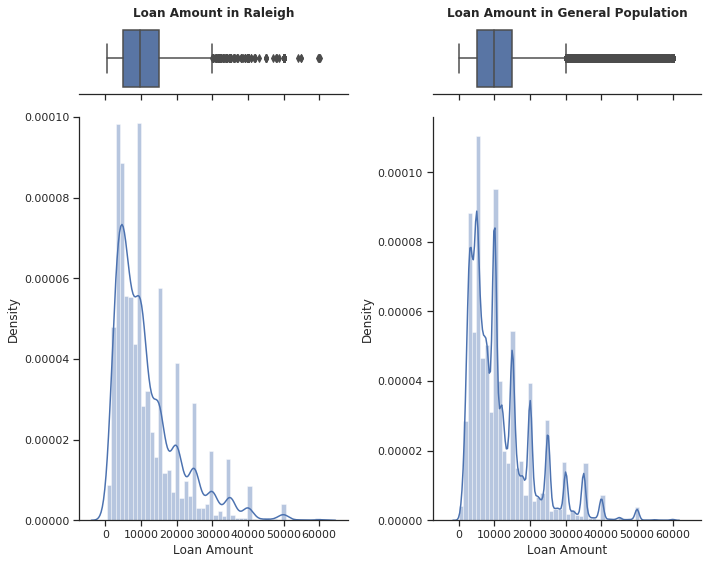

In [22]:
# Plot the loan amount histograms
density_pair(ral_df=merged_raleigh,
          pop_df=tu_data,
          col='loan_amnt',
          ral_title='Loan Amount in Raleigh',
          pop_title='Loan Amount in General Population',
          xlabel='Loan Amount',
          ylim=(0, 0.0001))

We see a quite similar loan amount distribution: a long right tail, with a median at $ \approx 10,000$, which quickly descends to 0.

Describe the loan amount distribution using `sns.distplot` in the Raleigh dataframe and in TU.

We also want to verify that the offered interest rate in Raleigh seem similar to those in the general population. 
Create a histogram to describe the distribution of offered interest rates in Raleigh and interest rates in the general population. Do the distributions look similar?

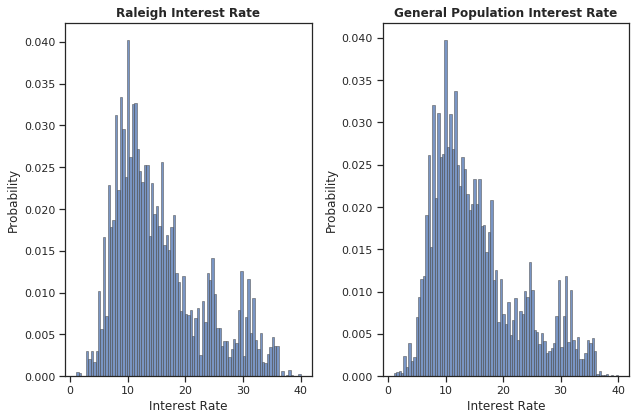

In [23]:
# Plot the interest rate histograms
hist_pair(ral_df=merged_raleigh,
          pop_df=tu_data,
          col='int_rate',
          ral_title='Raleigh Interest Rate',
          pop_title='General Population Interest Rate',
          xlabel='Interest Rate')

Very similar.

Describe the interest rate distribution using `sns.distplot` in the Raleigh dataframe and in TU.

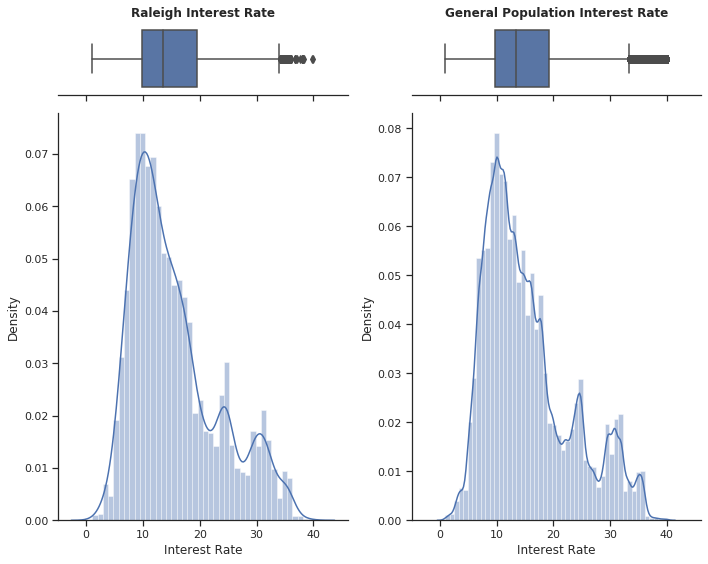

In [24]:
# Plot the interest rate histograms
density_pair(ral_df=merged_raleigh,
          pop_df=tu_data,
          col='int_rate',
          ral_title='Raleigh Interest Rate',
          pop_title='General Population Interest Rate',
          xlabel='Interest Rate')

Extremely similar, including the several peaks at the higher interest rates, at around 25, 30, 35 percent.

Additionally, we want to make sure the credit scores are not visibly different in Raleigh from the general population, as this might mean that the data we obtained from the town might not be representative of the general popuation.

Create a histogram to describe the distribution of credit scores in the Raleigh sample and in the general population. Do the distributions look similar? How many bins did you use?

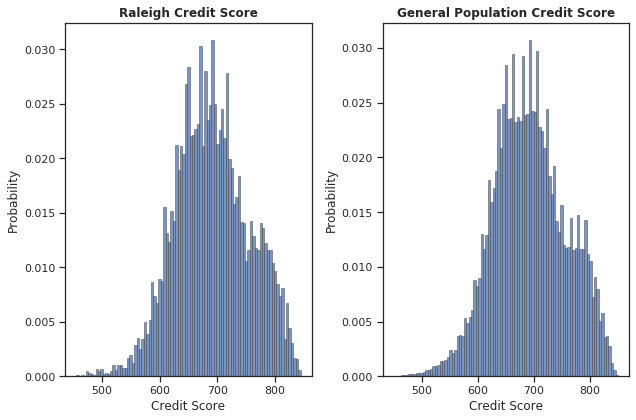

In [25]:
# Plot the Credit Score histograms
hist_pair(ral_df=merged_raleigh,
          pop_df=tu_data,
          col='credit_score',
          ral_title='Raleigh Credit Score',
          pop_title='General Population Credit Score',
          xlabel='Credit Score')

Describe the credit score distribution using `sns.distplot`  in the Raleigh dataframe and in TU.

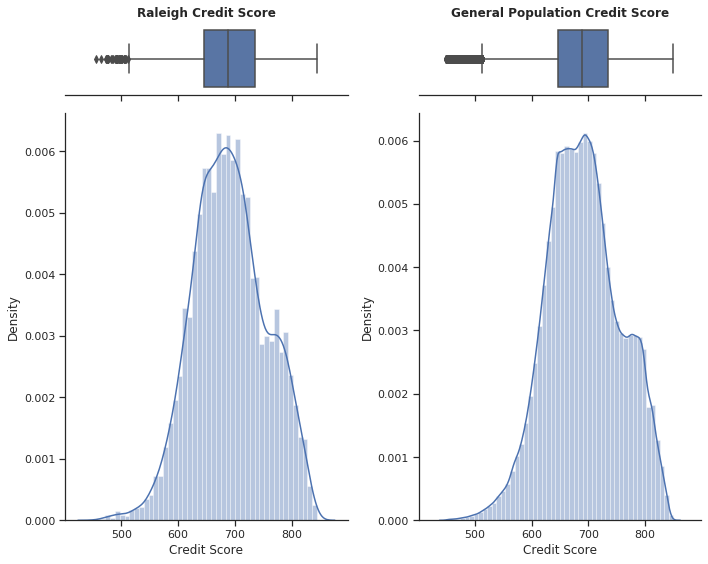

In [26]:
# Plot the Credit Score histograms
density_pair(ral_df=merged_raleigh,
          pop_df=tu_data,
          col='credit_score',
          ral_title='Raleigh Credit Score',
          pop_title='General Population Credit Score',
          xlabel='Credit Score')

Finally, check whether the loans in both datasets have similar distributions of term (i.e. the amount of months the borrower takes the loan for). What values of term exist in the data?

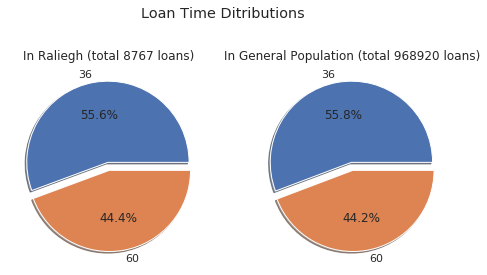

In [27]:
# Plot the loan time histograms
plt.subplot(1, 2, 1)
merged_raleigh.listing_term.astype(int).value_counts().plot.pie(explode=[0.05, 0.05], autopct='%1.1f%%', shadow=True, figsize=(8,8))
plt.title('In Raliegh (total {0} loans)'.format(merged_raleigh.shape[0]))
plt.ylabel('')

plt.subplot(1, 2, 2)
tu_data.listing_term.astype(int).value_counts().plot.pie(explode=[0.05, 0.05], autopct='%1.1f%%', shadow=True, figsize=(8,8))
plt.title('In General Population (total {0} loans)'.format(tu_data.shape[0]))
plt.ylabel('')
plt.suptitle('Loan Time Ditributions', y=0.78)
plt.show();

To conclude, in all features we see an almost identical distribution between Raleigh and the general population, meaning we can assume that it is a good test case to understand if the flyer program can be effective in general or not.

# CLT in action

One more thing before we start the test. Our goal is to check whether, for which we'll run some statistical test (you probably already know which) which checks if something belongs to a noraml distribution with some mean and some variance. But... is activation normally distributed in the Raliegh sample? 

In [28]:
#+2 points if you answer without plotting

"""
WILL BE DONE AFTER THE NEXT CELL, BECAUSE WE USE THE SAMPLE MEAN GENERATOR.
"""
pass

The reason why we can assume normality is because we're checking averages of samples and we're relying on the Central Limit Theorem. We won't prove the theorem, but let's test it for a bit. 

Write a function which takes a pandas series S and a natural number n and creates a series of means of samples (with replacement) of n entries from S. Decide for yourself on the length of the output series. You can also use a different data structure if you find it more suitable as the output.

In [29]:
def sample_mean(S, n, iterations=100, seed=123):
    # Set seed
    random.seed(seed)
    mean_arr = []
    for i in range(iterations):
        mean_arr.append(S.sample(n=n, replace=True).mean())
    return pd.Series(mean_arr)


We will now check for normality using the Shapiro-Wilk hypothesis test.

Denote $\bar{X} \sim F$. Our hypothesis:

$H_{0}: \bar{X} \sim N $ \
$\require{cancel} H_{1}: \bar{X} \cancel{\sim} N $

We will be looking at a 100,000 sample size, with replacement, of the offers accepted. \
We then will find the average across 1,000 iterations and test if this $\mathbb{R}^{1000}$ vector has a normal distribution with statistical significance.

In [30]:
"""
Testing the assumption without graphs
"""
S = merged_raleigh.offer_accepted

mean_series = sample_mean(S, 100000, 1000)
shapiro_test = stats.shapiro(mean_series)
p_value = shapiro_test.pvalue
print('The p-value for the Shapiro-Wilk test: {0}'.format(round(p_value, 3)))

if p_value > 0.05:
    print('We do not reject the Null hypothesis of a normal distribution.')

The p-value for the Shapiro-Wilk test: 0.713
We do not reject the Null hypothesis of a normal distribution.


Optionally- also create a function which, given the same input as above, plots a histogram of the series of means, and also indicates the mean of this series.

In [31]:

def plot_means(S, n, ax, iterations=1000, seed=123, title='', color=None):
    mean_arr = sample_mean(S, n, iterations, seed)


    mean_of_means = mean_arr.mean()  # Calculate mean of means
    sns.distplot(mean_arr, ax=ax)  # Create a density plot
    # Visual configurations
    ax.set_xlabel('Activation')
    ax.set_xticklabels(ax.get_xticks(), rotation = 45)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax.set_title(title + 'n={0}'.format(n))

    # Add a mean line in red
    ax.axvline(mean_of_means, color='r')
    ax.text(mean_of_means, 
            ax.get_ylim()[1] * 2 / 3,
            'mean={0}'.format(round(mean_of_means, 3)),
            rotation=90,
            verticalalignment='center',
            fontweight='semibold')


Generate plots of the series of means of activation in Raleigh and in TU for n = 1, 2, 5, 10, 100, 1000 and 1e6, and indicate their means. Does the distribution approach a normal distribution as $n\to\infty$ in your opinion?

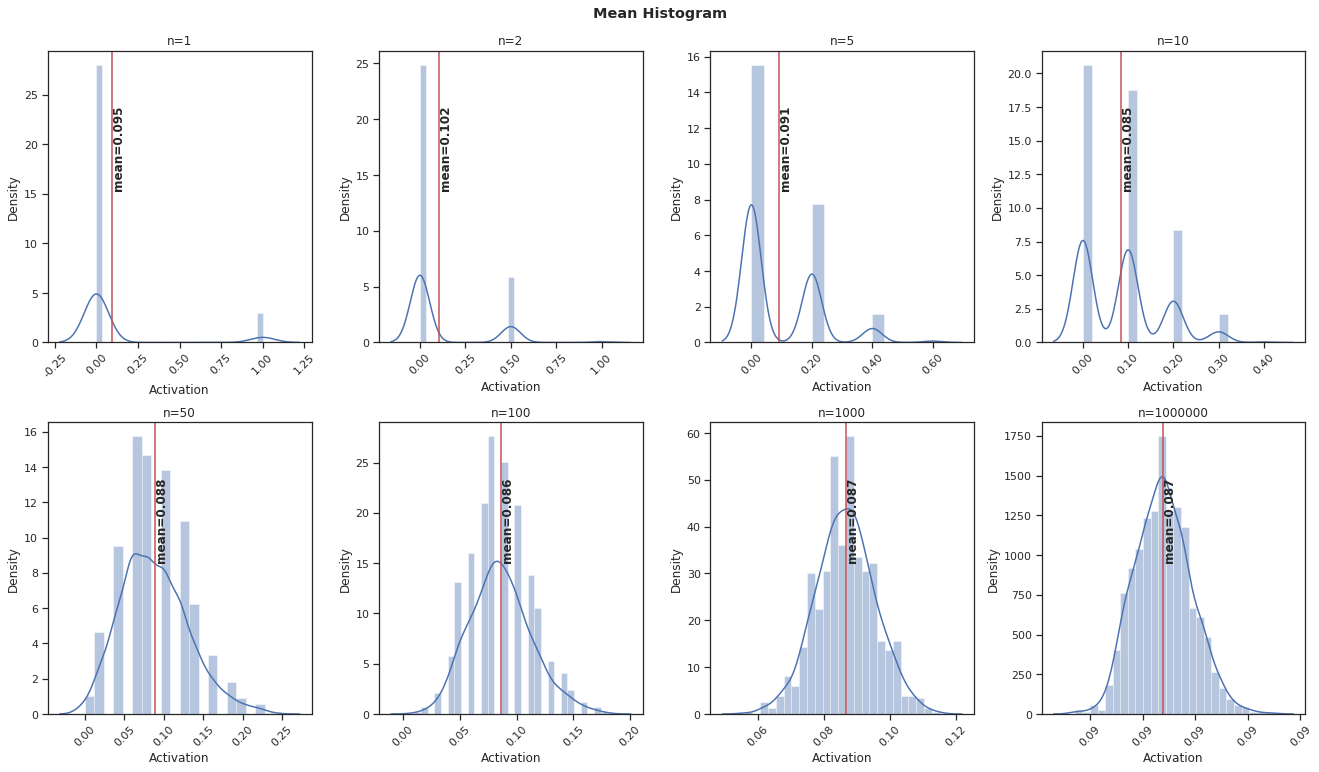

In [32]:
# Array of n values
n_vals = np.array([1, 2, 5, 10, 50, 100, 1000, 10**6])

# Initialize figure
fig, ax = plt.subplots(2, 4,
                      constrained_layout=True)

fig.set_size_inches(18.5, 10.5, forward=True)

# Plot a 4x2 grid of mean histograms
for i, n in enumerate(n_vals):
    j=0
    if i >= 4:
        j = 1
        i -= 4
    plot_means(S, n, ax[j][i])

plt.suptitle('Mean Histogram', fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

Now that your fuction is ready, it's time to make it part of our infrastucture:
* Inside the `pagayapro` repo, create a branch called `feature/{your_user_name}/clt_tester/`.
* Create a file called `clt.py` inside `~/pagayapro/users/{user_name}/assignment1/` 
* Copy the two finctions you just created into the file.
* Push your file to `main`, open a PR and ask your mentor to review it. Once approved, rebase and merge.

Done.

# Statistical test 

As mentioned in the Notion doc, the activation in Raleigh before deployment was measured at 6.85%. In this section, you will run a test to check whether the activation in Raleigh is indeed different following the flyer program. 

Run a statistical test to check whether the current activation rate in Raleigh is different from 6,85%:
1. What are your hypotheses?
2. Setting your confidence level at 95%, what is the probability of an error of type I in your test? What is the probability of a type II error? What is the power of your test?
3. Is the sample mean significantly different from the past value of 6.85?
4. Interpret your results. Can you declare the program as successful in increasing activation (what is the probability of wrongfully declaring it successful)?
5. Are there any other possible explanations for the change in activation that you observed? Discuss the possible drawbacks of our current test.

Use `proportions_ztestz` from `statsmodels.stats.proportion` in order to perform the test. Are your results significant?

We will be testing for a difference in activation after the deployment of the new flyer program. \
Denote $X \sim Ber(p)$ the random variable which represents the probabiliy of a customer in Raleigh for activation after the new flyer program deployed. \
Our hypotheses is as such:

$H_{0}: p = 0.0685 $ \
$H_{1}: p \ne 0.0685 $

Since we want a confidence level of 95%, we instantly know that the probability of a Type I error is $\alpha = 5\%$. \
The probability of a type II error and the power need to be calculated from the data.

In [33]:
# Define the variables for our proportion test
alpha = 0.05
count = S.sum()
n = S.shape[0]
p_0 = 0.0685
p_1 = S.mean()

Assuming normality (as shown in the CLT section):

$ \bar{X} \sim N(p, \frac{1}{\sqrt{n}}\sqrt{p(1-p)}^{2})$ \
$ \Downarrow $ \
We want to find the critical value C in which we reject $H_0$: \
$\mathbb{P}_{H_0}(|\bar{X}-p|\ge C) = 0.05$ \
\
$ \Phi(|\frac{C-p_0}{\sqrt{\frac{p_0(1-p_0)}{n}}}|) = 0.975 $ \
\
$ |\frac{C-p_0}{\sqrt{\frac{p_0(1-p_0)}{n}}}| = z^{-1}(0.975) = 1.96 $ \
\
$C = p_0 \pm 1.96\sqrt{\frac{p_0(1-p_0)}{n}}$

In [34]:
# Critical values of our hypothesis test
c_upper = p_0 + (norm.ppf(1 - (alpha / 2)) * (p_0*(1-p_0) / n)**0.5)
c_lower = p_0 - (norm.ppf(1 - (alpha / 2)) * (p_0*(1-p_0) / n)**0.5)

Now we can calculate $\beta$.

$\mathbb{P}_{H_1}(|\bar{X}|\ge C) = \beta $ \
\
$\mathbb{P}_{H_1}(\bar{X} \in (C_-, C_+)) = \beta$ \
\
$\mathbb{P}_{H_1}(\bar{X} \le C_+) - \mathbb{P}_{H_1}(\bar{X} \le C_-) = \beta$


In [35]:
# Type II error
beta = norm.cdf((c_upper - p_1) / ((p_1*(1 - p_1)/n)**0.5)) - norm.cdf((c_lower - p_1) / ((p_1*(1 - p_1)/n)**0.5))

print('The {0} value for our test: {1}'.format(chr(946), round(beta,3)))

The β value for our test: 0.0


The power of the test is exactly $ 1 - \beta = 1 $

In [36]:
# Calculate the test's p-value and decide if we reject the null hypothesis
stat, pval = proportions_ztest(count, n, p_0)
print('p-value={0}'.format(round(pval, 3)))
if pval < alpha / 2:
    print('We reject the Null hypothesis')
else:
    print('We do not reject the Null hypothesis')

p-value=0.0
We reject the Null hypothesis


In [37]:
# The confidence interval of our estimation
c_upper_alternative = p_1 + (norm.ppf(1 - (alpha / 2)) * (p_1*(1-p_1) / n)**0.5)
c_lower_alternative = p_1 - (norm.ppf(1 - (alpha / 2)) * (p_1*(1-p_1) / n)**0.5)

print('A 95% Confidence Interval: ({0}, {1})'.format(round(c_lower_alternative, 3), round(c_upper_alternative, 3)))

A 95% Confidence Interval: (0.081, 0.093)


As shown, we are (at least) 95% confident that the true parameter is higher than that of the pre-flyer program. 

That is to say there was a 24% - 42% (!) increase in the activation rate, with 95% statistical confidence.

Do you see any possible problems in your methodology? What other factors can explain the change in activation, if such a change exists?

First and foremost, we've shown in the CLT section that we converge to a normal distribution at high lengths of arrays - our data is not massive so the mean might not distribute normally and our whole test assumption might be incorrect.

# A/b test

In order to isolate temporal and environmental effects on activation, we'll run an a/b test, comparing the activation rate in Raleigh to that of Lubbock, TX, another town in which Pagaya operates without a flyer program. 

The activation forms for Lubbock also appear in the `offers` subdirectory of the `ASSIGNMENT1_DATA` folder. Read all files from this folder whose name contains the substring 'lubbock', and create a dataframe of final offers called `lubbock_df`, drop unnecessary rows from it, and enrich it with TU features.

In [38]:
lubbock_forms= (
    glob.glob(
        os.path.join(ASSIGNMENT1_DATA,"offers/*lubbock*")
    )
)

In [39]:
lubbock_df= pd.concat([pd.read_csv(path) for path in lubbock_forms])
lubbock_df_origin = lubbock_df.sort_values('offer_date')
lubbock_df = lubbock_df_origin.copy().groupby('id').last()

In [40]:
merged_lubbock = pd.merge(lubbock_df, tu_data,  how='left', left_on=['id','sequence_num'], right_on =['id','sequence_num'])

In [41]:
# Drop rows as before
merged_lubbock = merged_lubbock[merged_lubbock.loan_amnt <= 60150]
merged_lubbock = merged_lubbock[merged_lubbock.credit_score > 450]

What is the average interest rate in Lubbock? What is it among accepting borrowers?

In [42]:
print('The average interest rate in Lubbock: {0}%'.format(round(merged_lubbock.int_rate.mean(), 3)))

The average interest rate in Lubbock: 15.511%


What is the average credit score in Lubbock? What is it among accepting borrowers?

In [43]:
print('Lubbock Credit Score: {0}'.format(round(merged_lubbock.credit_score.mean(), 3)))

print('Lubbock Credit Score from those accepted: {0}'.format(round(merged_lubbock[merged_lubbock.offer_accepted].credit_score.mean(), 3)))

Lubbock Credit Score: 691.437
Lubbock Credit Score from those accepted: 730.534


What is the rate of activation in Lubbock?

In [44]:
print('Lubbock Activation Rate: {0}'.format(round(merged_lubbock.offer_accepted.mean(), 3)))

Lubbock Activation Rate: 0.047


## Caution about a/b test 

Note that this is not a classical a/b test. Usually, in such a test, one creates two random subgroups from the general population and applies a manipulation to one of them in order to see if the manipulation had an effect. However, in this case, it is very complicated to isolate a random subgroup from any population and deploy the flyer program only on it.
Thus, due to production limitation, we have to make do with what we got.

In order to justify the use of an a/b test for this situation, we should at least verify that the borrower population in Lubbock and Raleigh seem as though they were randomly selected from the general population. We have actually already checked it for Raleigh above. Add TU features to the loan amount, interest rate, credit score and term comparisons and see if there any major differences between the three populations (Lubbock, Raleigh and TU).

In [45]:
def density_three(ral_df, lub_df, pop_df, col, ral_title, lub_title, pop_title, xlabel, xlim=None, ylim=None):
    
    # Fig and Axes
    fig, ax = plt.subplots(nrows=2, ncols=3, sharex=True, 
                                        gridspec_kw={"height_ratios": (.15, .85)})

    # Raleigh Density
    sns.boxplot(x=ral_df[col], ax=ax[0][0])
    sns.distplot(ral_df[col], ax=ax[1][0])

    ax[0][0].set(yticks=[])
    sns.despine(ax=ax[1][0])
    sns.despine(ax=ax[0][0], left=True)
    ax[1][0].set_xlabel(xlabel)
    ax[0][0].set_xlabel('')
    ax[0][0].set_title(ral_title, fontweight='bold')
  
    # General Population Density
    sns.boxplot(x=pop_df[col], ax=ax[0][1])
    sns.distplot(pop_df[col], ax=ax[1][1])

    ax[0][1].set(yticks=[])
    sns.despine(ax=ax[1][1])
    sns.despine(ax=ax[0][1], left=True)
    ax[1][1].set_xlabel(xlabel)
    ax[0][1].set_xlabel('')
    ax[0][1].set_title(pop_title, fontweight='bold')
    
    # Lubbock Density
    sns.boxplot(x=lub_df[col], ax=ax[0][2])
    sns.distplot(lub_df[col], ax=ax[1][2])

    ax[0][2].set(yticks=[])
    sns.despine(ax=ax[1][2])
    sns.despine(ax=ax[0][2], left=True)
    ax[1][2].set_xlabel(xlabel)
    ax[0][2].set_xlabel('')
    ax[0][2].set_title(lub_title, fontweight='bold')
    
    
    
    if xlim:
        for i in range(2):
            for j in range(3):
                ax[i][j].set_xlim(xlim[0], xlim[1])
    if ylim:
        for j in range(3):
                ax[1][j].set_ylim(ylim[0], ylim[1])       
    
    # Present the plots
    fig.set_size_inches(12, 7, forward=True)
    plt.tight_layout()
    plt.show()    


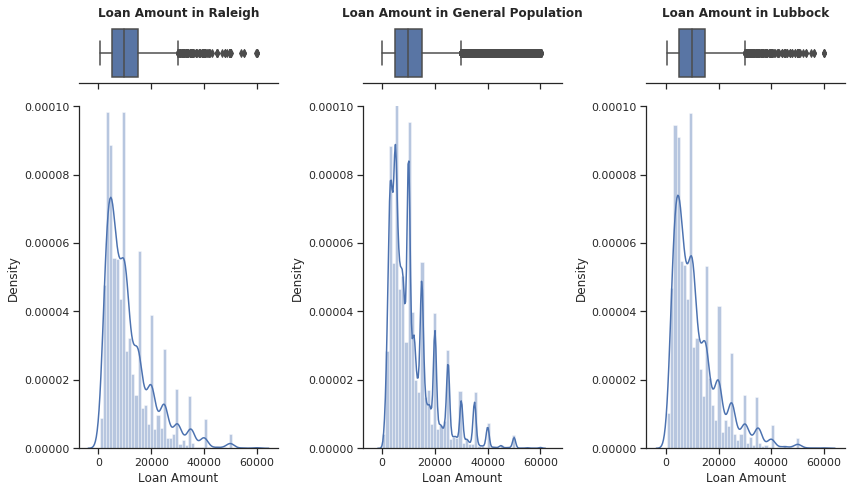

In [46]:
# Plot the loan amount histograms
density_three(ral_df=merged_raleigh,
          lub_df=merged_lubbock,
          pop_df=tu_data,
          col='loan_amnt',
          ral_title='Loan Amount in Raleigh',
          lub_title='Loan Amount in Lubbock',
          pop_title='Loan Amount in General Population',
          xlabel='Loan Amount',
          ylim=(0, 0.0001))


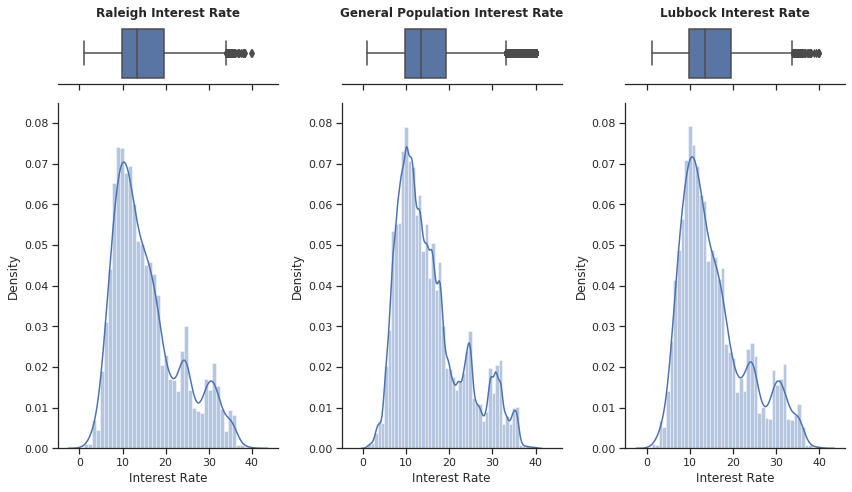

In [47]:
# Plot the interest rate histograms
density_three(ral_df=merged_raleigh,
          lub_df = merged_lubbock,
          pop_df=tu_data,
          col='int_rate',
          ral_title='Raleigh Interest Rate',
          lub_title='Lubbock Interest Rate',
          pop_title='General Population Interest Rate',
          xlabel='Interest Rate',
          ylim = (0, 0.085))

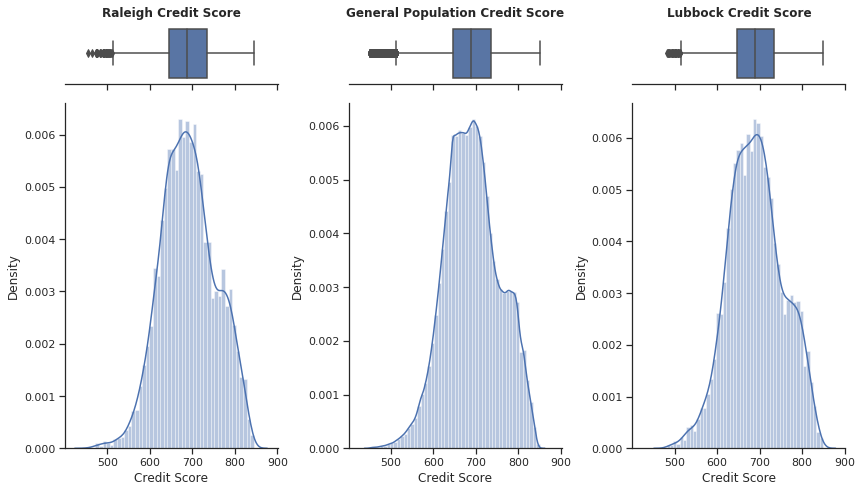

In [48]:
# Plot the Credit Score histograms
density_three(ral_df=merged_raleigh,
          lub_df = merged_lubbock,
          pop_df=tu_data,
          col='credit_score',
          ral_title='Raleigh Credit Score',
          lub_title='Lubbock Credit Score',
          pop_title='General Population Credit Score',
          xlabel='Credit Score')

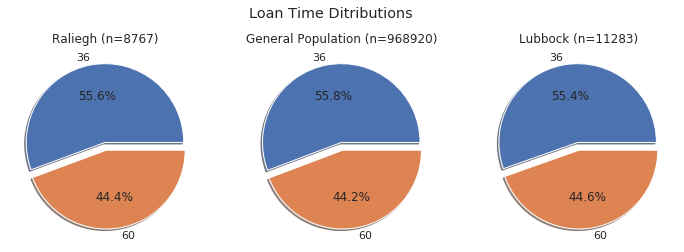

In [49]:
# Plot the loan time histograms
fig, ax = plt.subplots()
plt.subplot(1, 3, 1)
merged_raleigh.listing_term.astype(int).value_counts().plot.pie(explode=[0.05, 0.05], autopct='%1.1f%%', shadow=True, figsize=(8,8))
plt.title('Raliegh (n={0})'.format(merged_raleigh.shape[0]))
plt.ylabel('')

plt.subplot(1, 3, 2)
tu_data.listing_term.astype(int).value_counts().plot.pie(explode=[0.05, 0.05], autopct='%1.1f%%', shadow=True, figsize=(8,8))
plt.title('General Population (n={0})'.format(tu_data.shape[0]))
plt.ylabel('')


plt.subplot(1, 3, 3)
merged_lubbock.listing_term.astype(int).value_counts().plot.pie(explode=[0.05, 0.05], autopct='%1.1f%%', shadow=True, figsize=(8,8))
plt.title('Lubbock (n={0})'.format(merged_lubbock.shape[0]))
plt.ylabel('')
plt.suptitle('Loan Time Ditributions', y=0.78)
fig.set_size_inches(12, 7, forward=True)

plt.show();

As before, the Lubbock is also very similar in all feature distributions to Raleigh and to the general population.

## Performing the test

Use the function you created in the file `clt.py` to plot the series of means of activation in Raleigh and Lubbock for samples of size n= 1, 10, 1000 and 1e6, and compare the means of the two histograms. To they seem to converge to the same value?

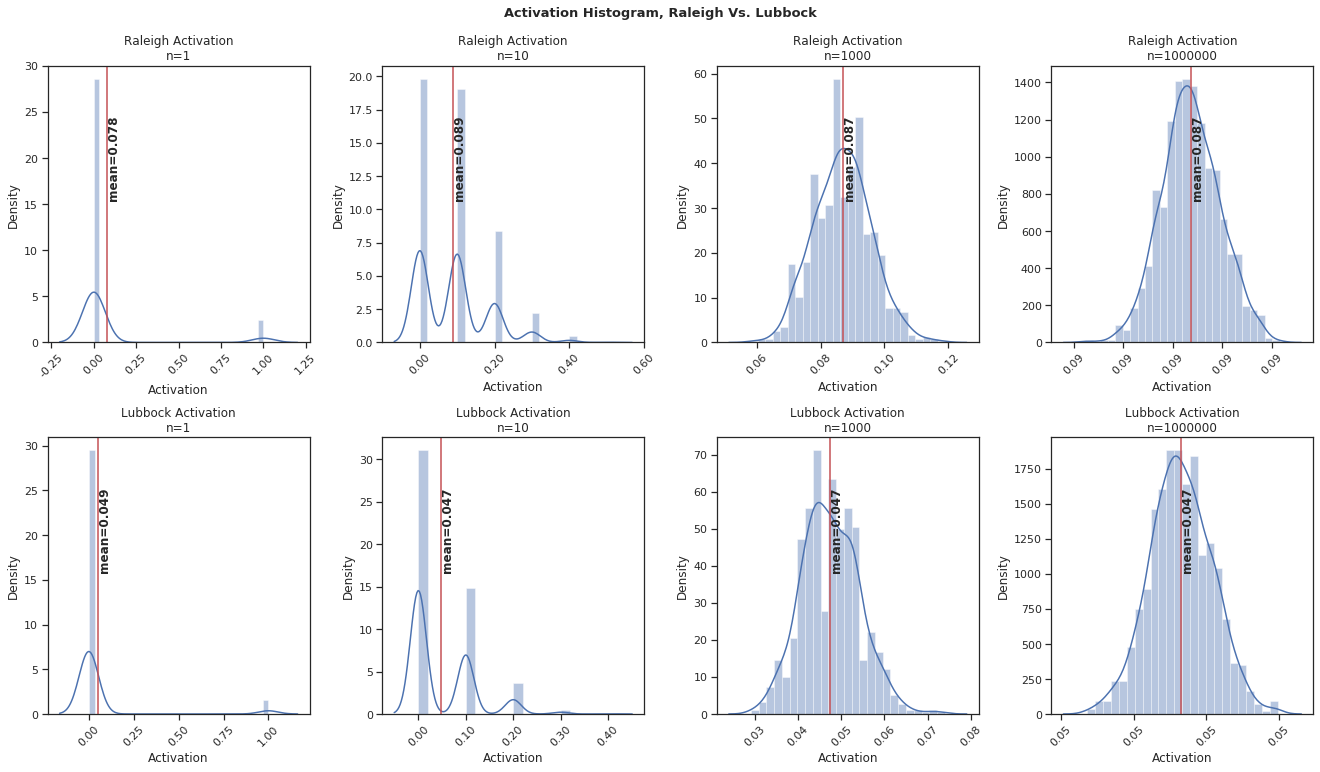

In [50]:
n_vals = np.array([1, 10, 1000, 10**6, 1, 10, 1000, 10**6])

fig, ax = plt.subplots(2, 4,
                      constrained_layout=True)

fig.set_size_inches(18.5, 10.5, forward=True)

for i, n in enumerate(n_vals):
    j=0
    if i >= 4:
        j = 1
        i -= 4
        plot_means(merged_lubbock.offer_accepted,
                   n,
                   ax[j][i],
                  title='Lubbock Activation\n')
    else:
        plot_means(merged_raleigh.offer_accepted,
                   n,
                   ax[j][i],
                  title='Raleigh Activation\n')

plt.suptitle('Activation Histogram, Raleigh Vs. Lubbock', fontsize=13, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

Apply a statistical test to see whether the activation rate in Raleigh, NC is significantly larger than Lubbock, TX. Clearly state and validate your test's assumption. 

1. What are your hypotheses?
2. Setting your confidence level at 95%, what is the probability of an error of type I in your test? What is the probability of a type II error?
3. Are the two samples significantly different? 
4. Interpret your results. Can you declare the program as successful in increasing activation? What is the probability of wrongfully declaring it successful?

Our hypothesis now:

$ H_0: p_{R} = p_{L} $ \
$ H_0: p_{R} \ge p_{L} $ 

As before, since we want a 95% confidence level, our probability of a type I error is $\alpha=0.05$.

Use the `proportions_ztestz` function from `statsmodels.stats.proportion` to perform a comparison between the activation probability in Lubbock and in Raleigh. 

In [55]:
count = np.array([merged_raleigh.offer_accepted.sum(), merged_lubbock.offer_accepted.sum()])
nobs = np.array([merged_raleigh.shape[0], merged_lubbock.shape[0]])
stat, pval = proportions_ztest(count, nobs, alternative='larger')

print('p-value={0}'.format(round(pval, 7)))
if pval < alpha:
    print('We reject the Null hypothesis')
else:
    print('We do not reject the Null hypothesis')

p-value=0.0
We reject the Null hypothesis


The samples are significantly different. We have a very low p-value meaning we conclude with statistical significance that the null hypothesis is to be rejected.

We now want to calculate $\beta$ and the test's power.

This time, we will be calculating it using the statsmodels module's help.

In [181]:
import statsmodels.stats.power as power

p_2 = merged_lubbock.offer_accepted.mean()

p_hat = ((merged_raleigh.shape[0]*p_1) + (merged_lubbock.shape[0]*p_2)) / (merged_lubbock.shape[0] + merged_raleigh.shape[0])

effect_size = (p_1 - p_2) / (p_hat * (1 - p_hat) * (merged_lubbock.shape[0]**(-1) + merged_raleigh.shape[0]**(-1)) )**0.5
nobs1 = merged_raleigh.shape[0]
ratio = merged_lubbock.shape[0] / nobs1
test_power = power.zt_ind_solve_power(effect_size=effect_size,
                        nobs1=nobs1,
                        alpha=0.05,
                        ratio=ratio,
                        alternative='larger')

print('The test power={0}, and {1}={2}'.format(test_power, chr(946), 1-test_power))

The test power=1.0, and β=0.0


Interprest your results; do you observe a significant change in activation in Raleigh? What is the probability of wrongfully declaring the program successful?

We have a minor probability for a type II error, and our test shows that the activation in raleigh is significantly (95% confidence) higher than that of lubbrock.

The probability of wrongfully declaring the program successful, a false positive, is $\alpha=0.05$.

# Testing for activation in sub-populations

Now that you applied the a/b test to the Lubbock and Raleigh datasets, it is now required that you make a similar comparison on different subsets of the data within various credit score and loan amount bins. To do so, let us first decide on how to segment our data.

You are asked to divide your data into 10 bins according to loan amount, and then divide each of those bins into 10 bins according to loan amount. The most staightforward way of doing this is by using the `pd.qcut` function; first dividing the data into 10 quantiles of credit score and then dividing each of these quantiles into 10 according to loan amount.

Divide your datasets as above and add two columns to your data which indicate the (credit_score, loan_amnt) of the bin.

In [56]:
merged_raleigh['bins_loan_amnt'] = pd.qcut(merged_raleigh.loan_amnt, 10, labels=False)
merged_lubbock['bins_loan_amnt'] = pd.qcut(merged_lubbock.loan_amnt, 10, labels=False)

# Initialize column
merged_raleigh['bins_credit_score'] = np.nan
merged_lubbock['bins_credit_score'] = np.nan

# Create the credit score bins
for b in merged_raleigh.bins_loan_amnt.unique():
    merged_raleigh.bins_credit_score[merged_raleigh.bins_loan_amnt == b] = pd.qcut(merged_raleigh.credit_score[merged_raleigh.bins_loan_amnt == b], 10, labels=False).astype(int)
    merged_lubbock.bins_credit_score[merged_lubbock.bins_loan_amnt == b] = pd.qcut(merged_lubbock.credit_score[merged_lubbock.bins_loan_amnt == b], 10, labels=False).astype(int)

Run an a/b test on each of the bins in your data and create a $10\times 10$ table containing the $p$ value of each test.

In [103]:
# Initialize table
pval_table = np.zeros(shape=(10, 10))

for i in range(10):
    for j in range(10):
        cur_count = np.array([merged_raleigh.query('bins_loan_amnt == @i and bins_credit_score == @j').offer_accepted.sum(), merged_lubbock.query('bins_loan_amnt == @i and bins_credit_score == @j').offer_accepted.sum()])
        cur_nobs = np.array([merged_raleigh.query('bins_loan_amnt == @i and bins_credit_score == @j').shape[0], merged_lubbock.query('bins_loan_amnt == @i and bins_credit_score == @j').shape[0]])
        pval_table[i, j] = proportions_ztest(cur_count, cur_nobs, alternative='larger')[1]
        
        

In [58]:
pval_table

array([[1.03588031e-03, 4.55375601e-05, 4.32625140e-02, 5.60840474e-02,
        2.41638785e-01, 1.47662975e-01, 1.08356063e-01, 2.21723094e-03,
        2.43510410e-01, 7.21043633e-01],
       [5.62642138e-03, 6.51075812e-02, 1.39978419e-01, 2.18003557e-02,
        1.40992171e-01, 2.43779767e-01, 4.46235494e-02, 6.57853759e-01,
        6.88329586e-01, 1.51652325e-01],
       [2.71424127e-02, 1.30754042e-01, 9.51533265e-01, 3.47796086e-02,
        2.38549986e-02, 3.21660629e-01, 4.64449797e-02, 5.34281349e-01,
        7.46365343e-01, 4.27963377e-02],
       [2.75927479e-04, 1.89578214e-02, 3.63484339e-02, 8.14117998e-03,
        1.82602202e-01, 5.30176198e-02, 4.02489258e-02, 4.66370583e-01,
        2.31964247e-01, 7.27920343e-01],
       [2.33545287e-03, 1.36591875e-04, 1.57714312e-02, 7.64780894e-01,
        3.95910921e-02, 2.89086367e-01, 7.65632352e-01, 2.07035578e-01,
        1.97337203e-02, 5.93272079e-02],
       [1.86857766e-01, 4.34047055e-01, 4.57153956e-02, 6.61085532e-02,
   

Use the [seaborn.heatmap](https://seaborn.pydata.org/generated/seaborn.heatmap.html) function to represent your table as a heatmap. You can also use it on a suitable table of boolean values to get a more robus representation of which experiments turned out significant.

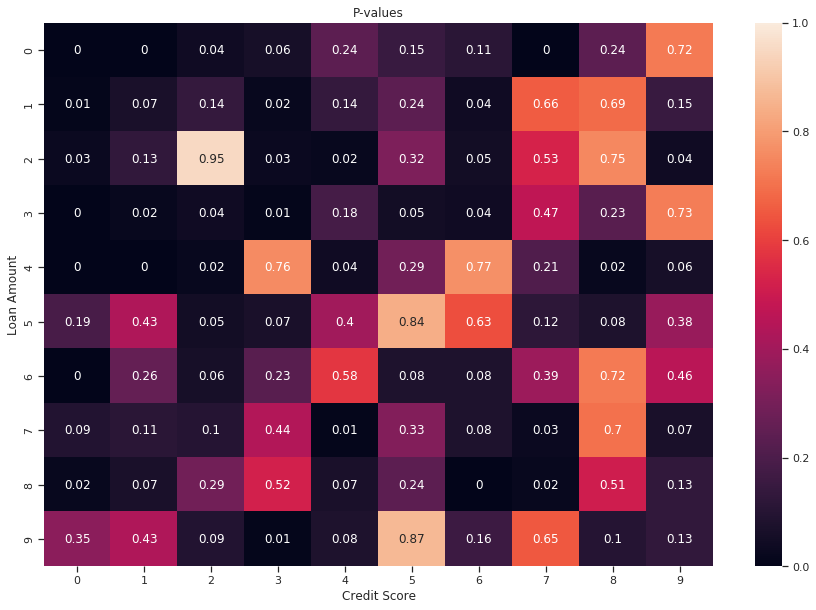

In [59]:
fig, ax = plt.subplots()

sns.heatmap(np.around(pval_table, decimals=2), annot=True, vmin=0, vmax=1)
plt.xlabel('Credit Score')
plt.ylabel('Loan Amount')
plt.title('P-values')
fig.set_size_inches(15, 10, forward=True)
plt.show()

What is the probability of falsely rejecting the null hypothesis in each cell? What is the probability of falsely rejecting the null hypothesis in at least one of the cells (i.e. what is the **family wise error rate**)?

In other words, given that we made $m$ experiments, with confidence level $\alpha$, what is the probabilty $\mathbb{P}\left(\bigcup_i X_i \le q_{\alpha}\right)$? 

_Note_: you may assume that sampling from different bins are independent.

The probability of falsely reject $H_0$ in each cell is 0.05 (did not change).

The probability of falsely rejecting at least one is: 1 - the probability of not falsely rejecting any null hypothesis.

This is exactly: 

$ 1 - (1-\alpha)^{m} = 1 - 0.95^{100} \approx 0.994 $


## Bonferroni correction 

One way of assuring that your FWER remains below $\alpha=0.05$ is to apply a <a href="https://en.wikipedia.org/wiki/Bonferroni_correction">**Bonferroni correction**</a>. This means that we set the signficance level of each individual test to $\alpha/m$, where $m=100$ is the number of tests (see, e.g., Wikipedia for an explanation). 

Use a Bonferroni correction on your segmented a/b test and output a $10\times10$ table of boolean values, indicating which test gave a significant result under this correction.

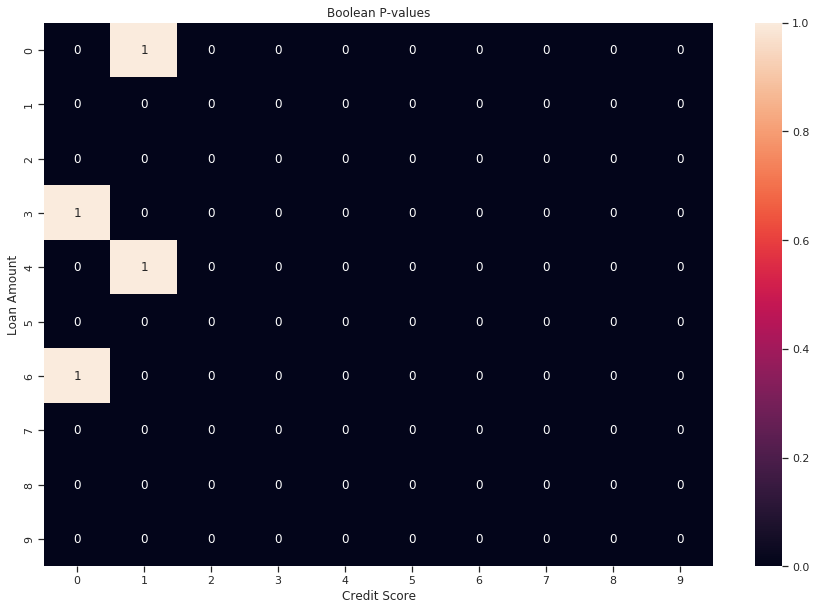

In [60]:
fig, ax = plt.subplots()

alpha_bonferroni = alpha / (10**2)
pval_table_bool = pval_table <= alpha_bonferroni
sns.heatmap(pval_table_bool, annot=True, vmin=0, vmax=1)
plt.xlabel('Credit Score')
plt.ylabel('Loan Amount')
plt.title('Boolean P-values')
fig.set_size_inches(15, 10, forward=True)
plt.show()

Use the [seaborn.heatmap](https://seaborn.pydata.org/generated/seaborn.heatmap.html) function to represent your table as a heatmap. You can also use it on a suitable table of boolean values to get a more robus representation of which experiments turned out significant.

How many of your tests came out significant under this correction?

0, although we do have tests with a p-value just slightly above the threshold of $\frac{\alpha}{m}$

Visualize your result using the [seaborn.heatmap]() function and compare to the previous heatmap.

## BH correction 

The Bonferroni correction is often criticized for being too restrictive, as you probably noticed in the last subsection. A more commonly used method for correcting $\alpha$ values is the Benjamini-Hochberg method. You can <a href="https://www.youtube.com/watch?v=K8LQSvtjcEo">check out the quest</a> for a nice explanation about it.

Start by arranging the $p$-values of your original test as a series and listing them in ascending order. You can use the `pd.DataFrame.stack` and `pd.Series.sort_values` methods.

In [129]:
pvalues_sorted = pd.Series(pval_table.flatten()).sort_values()

Plot your sorted $p$-values

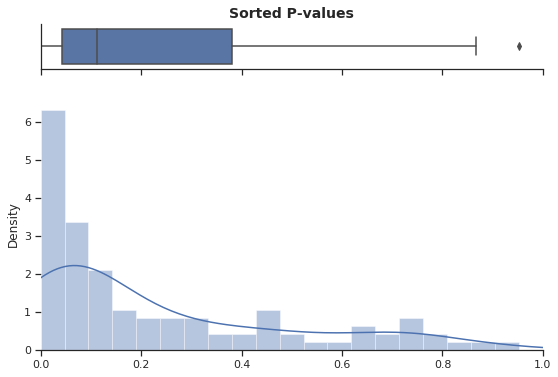

In [146]:
# Fig and Axes
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, 
                                    gridspec_kw={"height_ratios": (.15, .85)})

# Raleigh Density
sns.boxplot(x=pvalues_sorted, ax=ax[0])
sns.distplot(pvalues_sorted, bins=20, ax=ax[1])

ax[0].set(yticks=[])
sns.despine(ax=ax[0])
sns.despine(ax=ax[1], left=True)
ax[0].set_xlabel('')
ax[0].set_title('Sorted P-values', fontweight='bold', fontsize=14)
ax[0].set_xlim(0, 1)
plt.show()

We have a large bunch of p-values bins between 0-0.1 and a long right tail up to 1.

For each entry of the new series, compute the value compute the value $\frac{i}{m}\cdot\alpha$, where $i$ is the ordinal place of the entry (i.e. 1,2,...len(series)), $m=100$ and $\alpha=0.05$ as above. Add a plot of these values to your $p$-values plot.

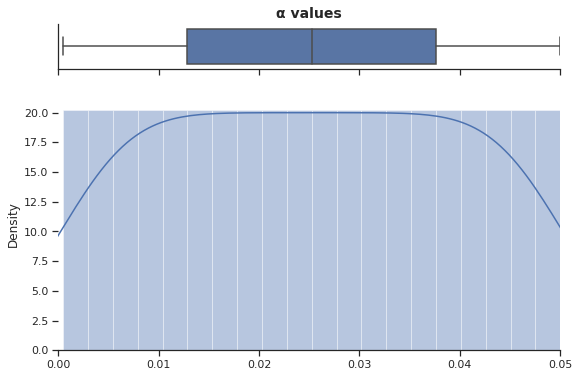

In [148]:
pvalues_sorted.reset_index(drop=True, inplace=True)

alpha_arr = pd.Series(alpha * (pvalues_sorted.index + 1) / (10**2))


# Fig and Axes
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, 
                                    gridspec_kw={"height_ratios": (.15, .85)})

# Raleigh Density
sns.boxplot(x=alpha_arr, ax=ax[0])
sns.distplot(alpha_arr, bins=20, ax=ax[1])

ax[0].set(yticks=[])
sns.despine(ax=ax[0])
sns.despine(ax=ax[1], left=True)
ax[0].set_xlabel('')
ax[0].set_title(chr(945) + ' values', fontweight='bold', fontsize=14)
ax[0].set_xlim(0, 0.05)
plt.show()

Uniformly distributed between 0 and 0.05.

Find the largest index $i$ for which the $p$-value in the $i$-th place in the series is smaller than $\frac{i}{m}\cdot\alpha$. That is- the last index in the plot you just created where the $p$-values line lies below the _adjusted_-$\alpha$ line.

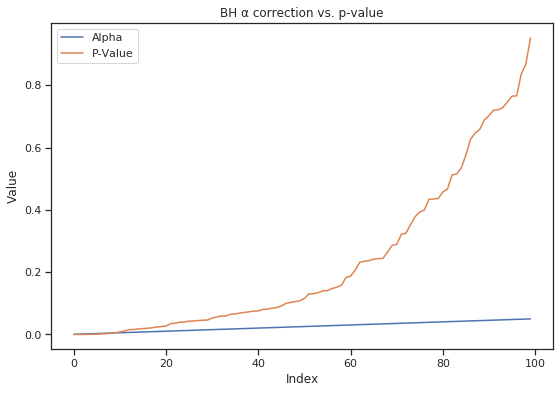

In [150]:
plt.plot(alpha_arr, label='Alpha')
plt.plot(pvalues_sorted, label='P-Value')
plt.title('BH ' + chr(945) + ' correction vs. p-value')
plt.ylabel('Value')
plt.xlabel('Index')
plt.legend()
plt.show()

In [151]:
to_reject = pvalues_sorted[pvalues_sorted <= alpha_arr]

print('p-values that pass the BH correction test:')
to_reject

p-values that pass the BH correction test:


0    1.191745e-07
1    4.553756e-05
2    1.365919e-04
3    2.759275e-04
4    9.885200e-04
5    1.035880e-03
6    2.217231e-03
7    2.335453e-03
dtype: float64

Reject the null hypothesis for all test before and including this index, and accept it for all others. Reformat your table into a $10\times 10$ dataframe; for which bins did we get a significant result in the corrected test?

In [152]:
to_reject = set(to_reject)
pval_table_bh = pval_table.copy()

# True if p-value is as found to pass threshold, False otherwise
for i in range(10):
    for j in range(10):
        if pval_table_bh[i, j] in to_reject:  # The probability for 2 p-values to be exactly the same is 0
            pval_table_bh[i, j] = True
        else:
            pval_table_bh[i, j] = False

Visualize your result using the [seaborn.heatmap]() function and compare to the previous heatmap.

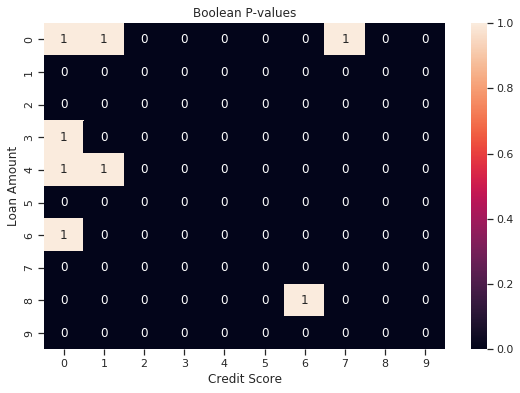

In [153]:
sns.heatmap(pval_table_bh, annot=True, vmin=0, vmax=1)
plt.xlabel('Credit Score')
plt.ylabel('Loan Amount')
plt.title('Boolean P-values')
fig.set_size_inches(15, 10, forward=True)
plt.show()

### Validating your results

You can validate your results (for both corrections) using the <a href= "https://www.statsmodels.org/dev/generated/statsmodels.stats.multitest.multipletests.html">`statsmodels.stats.multitest.multipletests`</a> package.

In [160]:
pvals_reject_bonferroni = multipletests(
    pvalues_sorted, alpha=0.05, method='bonferroni', returnsorted=False)[1][multipletests(
    pvalues_sorted, alpha=0.05, method='bonferroni', returnsorted=False)[0] == True]

In [176]:
pval_our_results_bonferroni = pval_table[pval_table_bool]*100. # To percentage
pval_our_results_bonferroni.sort()
pvals_reject_bonferroni.sort()

np.array_equal(pval_our_results_bonferroni, pvals_reject_bonferroni)

True

Our bonferroni results were absolutely correct!

We can see that the validation is consistent with our previous results for the Bonferroni correction.